# Results from the web app in observational data
In this notebook, we create the input CSV files we use in the web app from observational data. Then, we analyse the results with simple metrics. First, we import the Python packages.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.visualization import hist

from sklearn.dummy import DummyRegressor
from sklearn.metrics import median_absolute_error, r2_score

## Read observational file
Here, we read the observational file we created for the Paper II in our series of "Diagnosing the interstellar medium of galaxies with far-infrared emission lines".

In [2]:
dataset = Table.read('../data/raw/complete_sample_clean.ecsv',
                     format='ascii.ecsv')

We send the astropy table to a pandas dataframe to manage and order the data

In [3]:
dat_pd = dataset.to_pandas()

dat_pd['z'] = np.log10(1+dat_pd['z'])
dat_pd['SFR'] = np.log10(dat_pd['SFR'])
dat_pd['Lum_OIII_52'] = np.log10(dat_pd['LOIII52'])
dat_pd['Lum_NIII_57'] = np.log10(dat_pd['LNIII57'])
dat_pd['Lum_OI_63'] = np.log10(dat_pd['LOI63'])
dat_pd['Lum_OIII_88'] = np.log10(dat_pd['LOIII88'])
dat_pd['Lum_CII_158'] = np.log10(dat_pd['LCII'])
dat_pd['Lum_NII_205'] = np.log10(dat_pd['LNII205'])

We describe the data to see how many rows are empty

In [4]:
df1 = dat_pd.describe(include='all')
df1.loc['dtype'] = dat_pd.dtypes
df1.loc['size'] = len(dat_pd)
df1.loc['% count'] = dat_pd.isnull().mean()

df1[['Lum_OIII_52', 'Lum_NIII_57', 'Lum_OI_63', 'Lum_OIII_88',
    'LNII122', 'LOI145', 'Lum_CII_158', 'Lum_NII_205']]

,Lum_OIII_52,Lum_NIII_57,Lum_OI_63,Lum_OIII_88,LNII122,LOI145,Lum_CII_158,Lum_NII_205
count,112.0,179.0,736.0,508.0,430.0,308.0,1223.0,683.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8.362395,7.430547,8.003097,7.699656,779310585.987567,2166851031.766403,8.253675,6.940747
std,1.229987,1.014738,1.197373,1.178414,2891976116.040114,14318058845.628651,1.179155,1.068413
min,5.322747,4.700707,2.509141,3.118188,160.032794,433.969691,2.69897,2.715017
25%,7.508037,6.790074,7.522987,7.063655,2984981.328632,2301437.999405,7.752031,6.395243
50%,8.38069,7.507343,8.123783,7.711462,20029860.007844,13703034.84673,8.431364,6.918348
75%,8.96749,8.029805,8.629822,8.316354,76435835.265747,85262488.994828,8.924279,7.406666


We select the four different sets we are going to test in the web app.

In [5]:
dat_pd_A = dat_pd.dropna(subset=['z', 'SFR', 'Lum_CII_158', 'Lum_OI_63'])
dat_pd_B = dat_pd.dropna(subset=['z', 'SFR', 'Lum_CII_158', 'Lum_OIII_88'])
dat_pd_C = dat_pd.dropna(subset=['z', 'SFR', 'Lum_OI_63',
                                 'Lum_CII_158', 'Lum_NII_205'])
dat_pd_D = dat_pd.dropna(subset=['z', 'SFR', 'Lum_NIII_57', 'Lum_OIII_52'])

We print the maximum redshifts for each dataset

In [6]:
list_sets = [dat_pd_A, dat_pd_B, dat_pd_C, dat_pd_D]
for stp in list_sets:
    print(np.round((10**stp['z'] - 1).max(), 3))

3.127
6.081
2.17
3.043


Finally we save these data frames in CSV files

In [7]:
dat_pd_A.to_csv('../data/interim/inputs_DiagISM/Obsdata_set_A.csv', mode='w',
                columns=['z', 'Lum_CII_158', 'Lum_OI_63'], index=False)
dat_pd_B.to_csv('../data/interim/inputs_DiagISM/Obsdata_set_B.csv', mode='w',
                columns=['z', 'Lum_CII_158', 'Lum_OIII_88'], index=False)
dat_pd_C.to_csv('../data/interim/inputs_DiagISM/Obsdata_set_C.csv', mode='w',
                columns=['z', 'Lum_OI_63', 'Lum_CII_158', 'Lum_NII_205'], index=False)
dat_pd_D.to_csv('../data/interim/inputs_DiagISM/Obsdata_set_D.csv', mode='w',
                columns=['z', 'Lum_NIII_57', 'Lum_OIII_52'], index=False)

## Results metrics
We estimate the median absolute error and r$^2$ metrics to compare the two models in a table

In [7]:
for model in ['M8all', 'M2plus']:
    for istp, sample in enumerate(['A', 'B', 'C', 'D']):
        file = '../data/processed/outputs_DiagISM/obs_sfr/DiagISM_result_' + \
            model+'_SFR_'+sample+'.csv'
        results = Table.read(file,
                             format='ascii.csv', header_start=5)
        with open(file, "r") as metric:
            score_train = (float(metric.readlines()[3].split(':')[-1]))
        mae = median_absolute_error(list_sets[istp]['SFR'], results['mean'])
        r2_val = r2_score(list_sets[istp]['SFR'], results['mean'])
        print(model, sample, score_train, np.round(r2_val, 3), np.round(mae, 2))

M8all A 0.969 0.712 0.41
M8all B 0.969 0.753 0.41
M8all C 0.969 0.356 0.56
M8all D 0.969 0.308 0.83
M2plus A 0.929 0.796 0.33
M2plus B 0.934 0.859 0.29
M2plus C 0.952 0.729 0.41
M2plus D 0.857 0.378 0.79


We compare these metrics with a `DummyRegressor` to set the baseline

In [8]:
Dreg = DummyRegressor()
Dreg.fit(dat_pd_A[['z', 'Lum_CII_158', 'Lum_OIII_88']], dat_pd_A['SFR'])
DumPred = Dreg.predict(dat_pd_A[['z', 'Lum_CII_158', 'Lum_OIII_88']])

In [9]:
print('MAE: ', np.round(median_absolute_error(dat_pd_A['SFR'], DumPred), 3))
print('R2: ', r2_score(dat_pd_A['SFR'], DumPred))

MAE:  0.69
R2:  0.0


## Error estimations
We plot how the errors change with respect to the mean predicted value for the two models and four sets.

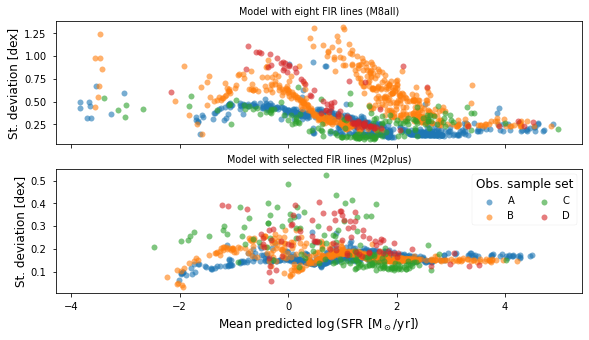

In [10]:
lab_models = ['Model with eight FIR lines (M8all)',
              'Model with selected FIR lines (M2plus)']
with plt.style.context(('seaborn-paper')):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    fig, axs = plt.subplots(2, 1, figsize=(9.44, 5), sharex=True)
    color_stp = ['C'+str(i) for i in range(4)]
    for imodel, model in enumerate(['M8all', 'M2plus']):
        axs[imodel].set_title(lab_models[imodel])
        for istp, sample in enumerate(['A', 'B', 'C', 'D']):
            file = '../data/processed/outputs_DiagISM/obs_sfr/DiagISM_result_' + \
                model+'_SFR_'+sample+'.csv'
            results = Table.read(file,
                                 format='ascii.csv', header_start=5)
            axs[imodel].scatter(results['mean'],
                                results['std'],
                                label=sample,
                                c=color_stp[istp], alpha=0.6)
            axs[imodel].set_ylabel('St. deviation [dex]')
    plt.legend(ncol=2, title='Obs. sample set')
    plt.xlabel(r'Mean predicted $\log$(SFR [M$_\odot$/yr])')
#     plt.savefig('../figures/Errors_SFR.pdf',
#                 dpi=300, bbox_inches='tight')  # For Paper

## Other physical parameters
The majority of the galaxies in the set B are located in the local Universe (>90%). So, we split the set in two to highlight the location of the high-$z$ galaxies.

In [11]:
highU = dat_pd_B['z'] >= np.log10(1+0.1)
print('Percentage of galaxies with z>0.1: %.2f%%' %
      ((sum(highU)/len(dat_pd_B))*100))

Percentage of galaxies with z>0.1: 9.18%


Then, we plot the errors for all the parameters retrieved by DiagISM

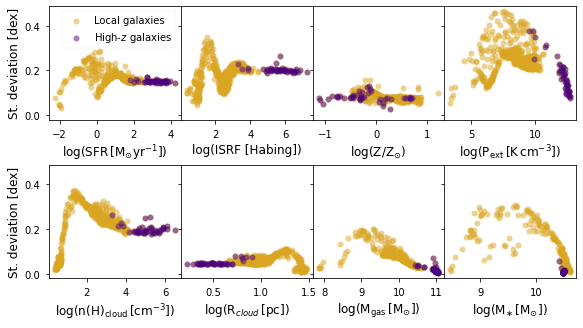

In [12]:
stps = ['SFR', 'ISRF', 'metallicity', 'pressure',
        'density', 'cloudSize',  'gasMass',  'stellarMass']
lab_pars = [r'$\rm{SFR}\, [\rm{M}_{\odot} \rm{yr}^{-1}]$', r'ISRF [Habing]', r'$\rm{Z/Z}_{\odot}$',
            r'P$_{\rm{ext}}\, [\rm{K\, cm}^{-3}]$', r'n(H)$_{\rm{cloud}}\, [\rm{cm}^{-3}]$',
            r'R$_{cloud}\, [\rm{pc}]$', r'$\rm{M}_{\rm{gas}}\, [\rm{M}_{\odot}]$',
            r'$\rm{M}_{\ast}\, [\rm{M}_{\odot}]$', ]
with plt.style.context(('seaborn-paper')):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    fig, axes = plt.subplots(2, 4, figsize=(9.44, 5), sharey=True)
    axs = axes.ravel()
    for istp, sample in enumerate(stps):
        file = '../data/processed/outputs_DiagISM/obs_sfr/DiagISM_result_M2plus_'+sample+'_B.csv'
        results = Table.read(file,
                             format='ascii.csv', header_start=5)
        axs[istp].scatter(results['mean'],
                          results['std'],
                          c='goldenrod', label='Local galaxies',
                          alpha=0.5)
        if sample == 'B':
            highz_highsfr = np.where(results['mean'] > 3.5)
        axs[istp].scatter(results['mean'][highU],
                          results['std'][highU],
                          c='indigo', label=r'High-$z$ galaxies',
                          alpha=0.5)
        axs[istp].set_xlabel('log('+lab_pars[istp]+')')
        if istp == 0:
            axs[istp].legend()
    axs[0].set_ylabel('St. deviation [dex]')
    axs[4].set_ylabel('St. deviation [dex]')
    plt.subplots_adjust(wspace=0, hspace=0.4)
#     plt.savefig('../figures/Errors_parameters.pdf',
#                 dpi=300, bbox_inches='tight')  # For Paper

We verify (print) which galaxies have those overestimated SFR in the model

In [13]:
highsfr_file = Table.read('../data/processed/outputs_DiagISM/obs_sfr/DiagISM_result_M2plus_SFR_B.csv',
                          format='ascii.csv', header_start=5)
highz_highsfr = highU & (highsfr_file['mean'] > 3.5)

In [14]:
dat_pd_B[highz_highsfr][['Name', 'SFR', 'SIMBADType',
                         'mu', 'mu_err', 'Limmu', 'mu_flag', 'Reference']]

,Name,SFR,SIMBADType,mu,mu_err,Limmu,mu_flag,Reference
1427,HERMES J105751.1+573027,3.176938,Galaxy,10.9,0.7,0,1,2018MNRAS.473...20R
1429,H-ATLAS J084933.4+021443,3.556770,Galaxy,2.8,0.2,0,1,2018MNRAS.481...59Z
1437,[BPA2013] H-ATLAS J141351.9-000026 lens,3.636786,GravLens,1.8,0.3,0,1,2018MNRAS.481...59Z
1440,[NKC2016] HELMS2,3.373105,LensedG,1.0,99.0,1,1,2018MNRAS.481...59Z
1441,[NKC2016] HELMS7,3.227734,LensedG,1.0,99.0,1,1,2018MNRAS.481...59Z
1443,NAME NAv1.777,3.468219,Galaxy,1.0,99.0,1,1,2018MNRAS.481...59Z
1444,HerBS 20,3.007944,Galaxy,1.0,99.0,1,1,2018MNRAS.481...59Z
1450,H-ATLAS J222536.3-295646,2.858088,Radio(sub-mm),1.0,99.0,1,1,2018MNRAS.481...59Z
1451,HerBS 17,3.239467,Galaxy,1.0,99.0,1,1,2018MNRAS.481...59Z
1453,HerBS 18,3.231704,Galaxy,1.0,99.0,1,1,2018MNRAS.481...59Z


## Correlation between observed and predicted values
To show a graphical differences between the two models and the four sets we plot the predicted values of SFR against the observed (observational catalog) value.

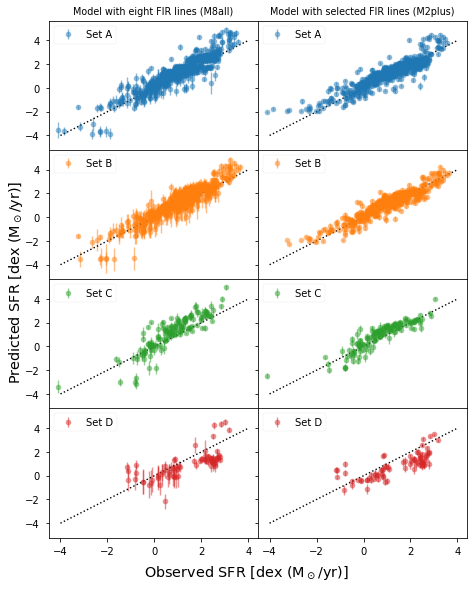

In [33]:
# with plt.style.context(('seaborn-talk')):
#     fig, axs = plt.subplots(4, 2, figsize=(10, 8), sharey=True, sharex=True)
with plt.style.context(('seaborn-paper')):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    fig, axs = plt.subplots(4, 2, figsize=(6.5, 8), sharey=True, sharex=True)
    for imodel, model in enumerate(['M8all', 'M2plus']):
        axs[0, imodel].set_title(lab_models[imodel])
        for istp, sample in enumerate(['A', 'B', 'C', 'D']):
            file = '../data/processed/outputs_DiagISM/obs_sfr/DiagISM_result_' + \
                model+'_SFR_'+sample+'.csv'
            results = Table.read(file,
                                 format='ascii.csv', header_start=5)
            axs[istp, imodel].errorbar(list_sets[istp]['SFR'],
                                       results['mean'],
                                       yerr=results['std'],
                                       label='Set '+sample, fmt='o',
                                       alpha=0.5, c=color_stp[istp])
            axs[istp, imodel].legend()
            axs[istp, imodel].plot([-4, 4], [-4, 4], ls=':', c='k')
    plt.tight_layout()
    fig.supylabel(r'Predicted SFR [dex (M$_\odot$/yr)]', x=-0.01)
    fig.supxlabel(r'Observed SFR [dex (M$_\odot$/yr)]', va='top')
    plt.subplots_adjust(wspace=0, hspace=0.0)
    plt.savefig('../figures/True_predictions.pdf',
                dpi=300, bbox_inches='tight')  # For Paper
#     plt.savefig('../figures/True_predictions.png',
#                 dpi=300, bbox_inches='tight')  # For Presentation

## Predictions for observational sample (set B)
We organise the results of the set B. First, we present those for a sample of ten galaxies in $\LaTeX$, then as a machine-readable format.

In [15]:
predictions = dat_pd_B[['z', 'SIMBADName']].copy()
# We add the 'z' to retrain the dataframe but we do not use it
for istp, sample in enumerate(stps):
    file = '../data/processed/outputs_DiagISM/obs_sfr/DiagISM_result_M2plus_'+sample+'_B.csv'
    results = Table.read(file,
                         format='ascii.csv', header_start=5)
    mean = np.array(['%.2f' % val for val in results['mean']])
    err = np.array(['%.2f' % val for val in results['std']])
    loc = np.where(err == '0.00')
    err[loc] = '0.01'
    predictions.loc[:, lab_pars[istp]] = list(map(r' $\pm$ '.join,
                                                  zip(mean, err)))

In [16]:
predictions[:10]

,z,SIMBADName,"$\rm{SFR}\, [\rm{M}_{\odot} \rm{yr}^{-1}]$",ISRF [Habing],$\rm{Z/Z}_{\odot}$,"P$_{\rm{ext}}\, [\rm{K\, cm}^{-3}]$","n(H)$_{\rm{cloud}}\, [\rm{cm}^{-3}]$","R$_{cloud}\, [\rm{pc}]$","$\rm{M}_{\rm{gas}}\, [\rm{M}_{\odot}]$","$\rm{M}_{\ast}\, [\rm{M}_{\odot}]$"
0,0.014100,Mrk 1506,1.85 $\pm$ 0.18,3.39 $\pm$ 0.24,0.55 $\pm$ 0.07,9.05 $\pm$ 0.41,3.30 $\pm$ 0.29,0.97 $\pm$ 0.08,10.42 $\pm$ 0.04,10.48 $\pm$ 0.01
8,0.000781,NAME Centaurus A,0.63 $\pm$ 0.16,2.10 $\pm$ 0.21,0.32 $\pm$ 0.08,7.83 $\pm$ 0.29,1.77 $\pm$ 0.33,1.12 $\pm$ 0.08,10.09 $\pm$ 0.07,10.53 $\pm$ 0.04
9,0.000608,NAME Circinus Galaxy,0.51 $\pm$ 0.15,1.97 $\pm$ 0.25,0.26 $\pm$ 0.08,7.60 $\pm$ 0.29,1.52 $\pm$ 0.36,1.18 $\pm$ 0.10,10.04 $\pm$ 0.07,10.51 $\pm$ 0.06
12,0.004321,ESO 173-15,1.76 $\pm$ 0.16,3.10 $\pm$ 0.23,0.60 $\pm$ 0.08,9.37 $\pm$ 0.32,3.19 $\pm$ 0.27,0.91 $\pm$ 0.07,10.39 $\pm$ 0.04,10.50 $\pm$ 0.02
13,0.004192,ESO 317-23,0.82 $\pm$ 0.17,2.25 $\pm$ 0.16,0.39 $\pm$ 0.08,8.18 $\pm$ 0.28,2.11 $\pm$ 0.29,1.06 $\pm$ 0.06,10.16 $\pm$ 0.06,10.55 $\pm$ 0.03
14,0.008813,ESO 350-38,1.55 $\pm$ 0.22,3.08 $\pm$ 0.22,0.44 $\pm$ 0.08,8.44 $\pm$ 0.38,2.81 $\pm$ 0.32,1.09 $\pm$ 0.07,10.34 $\pm$ 0.06,10.47 $\pm$ 0.02
17,0.016114,Mrk 477,1.51 $\pm$ 0.18,2.79 $\pm$ 0.22,0.47 $\pm$ 0.08,8.91 $\pm$ 0.40,2.76 $\pm$ 0.31,1.01 $\pm$ 0.08,10.33 $\pm$ 0.05,10.49 $\pm$ 0.01
18,0.000087,IC 10,-1.97 $\pm$ 0.10,0.38 $\pm$ 0.10,-0.30 $\pm$ 0.12,5.15 $\pm$ 0.15,0.41 $\pm$ 0.02,1.36 $\pm$ 0.03,8.43 $\pm$ 0.05,8.95 $\pm$ 0.15
21,0.002684,IC 1953,0.23 $\pm$ 0.19,1.42 $\pm$ 0.33,0.11 $\pm$ 0.08,7.10 $\pm$ 0.30,0.91 $\pm$ 0.26,1.36 $\pm$ 0.09,9.88 $\pm$ 0.10,10.32 $\pm$ 0.17
22,0.002123,IC 2554,0.75 $\pm$ 0.17,2.13 $\pm$ 0.20,0.33 $\pm$ 0.08,8.05 $\pm$ 0.30,1.91 $\pm$ 0.32,1.10 $\pm$ 0.07,10.13 $\pm$ 0.06,10.53 $\pm$ 0.04


We save the predictions of the first ten rows for the $\LaTeX$

In [18]:
to_print = Table.from_pandas(predictions[predictions.columns[1:]])
to_print[:10].write('../data/processed/predictions.tex',
                    format='latex', overwrite=True)

Then, we save the machine-readable table with some additional columns

In [20]:
pred_readable = dat_pd_B[['SIMBADName', 'RA', 'DEC', 'z']].copy()
for istp, sample in enumerate(stps):
    file = '../data/processed/outputs_DiagISM/obs_sfr/DiagISM_result_M2plus_'+sample+'_B.csv'
    results = Table.read(file,
                         format='ascii.csv', header_start=5)
    mean = np.round(results['mean'], 3)
    err = np.round(results['std'], 3)
    pred_readable.loc[:, lab_pars[istp]] = mean
    pred_readable.loc[:, lab_pars[istp]+'_err'] = err

In [21]:
pred_readable

,SIMBADName,RA,DEC,z,"$\rm{SFR}\, [\rm{M}_{\odot} \rm{yr}^{-1}]$","$\rm{SFR}\, [\rm{M}_{\odot} \rm{yr}^{-1}]$_err",ISRF [Habing],ISRF [Habing]_err,$\rm{Z/Z}_{\odot}$,$\rm{Z/Z}_{\odot}$_err,"P$_{\rm{ext}}\, [\rm{K\, cm}^{-3}]$","P$_{\rm{ext}}\, [\rm{K\, cm}^{-3}]$_err","n(H)$_{\rm{cloud}}\, [\rm{cm}^{-3}]$","n(H)$_{\rm{cloud}}\, [\rm{cm}^{-3}]$_err","R$_{cloud}\, [\rm{pc}]$","R$_{cloud}\, [\rm{pc}]$_err","$\rm{M}_{\rm{gas}}\, [\rm{M}_{\odot}]$","$\rm{M}_{\rm{gas}}\, [\rm{M}_{\odot}]$_err","$\rm{M}_{\ast}\, [\rm{M}_{\odot}]$","$\rm{M}_{\ast}\, [\rm{M}_{\odot}]$_err"
0,Mrk 1506,04 33 11.0958,+05 21 15.617,0.014100,1.850,0.176,3.394,0.236,0.552,0.073,9.051,0.408,3.298,0.294,0.975,0.082,10.418,0.042,10.480,0.006
8,NAME Centaurus A,13 25 27.6150,-43 01 08.805,0.000781,0.627,0.157,2.098,0.205,0.315,0.079,7.828,0.290,1.773,0.334,1.123,0.078,10.089,0.065,10.531,0.042
9,NAME Circinus Galaxy,14 13 09.906,-65 20 20.47,0.000608,0.511,0.152,1.973,0.247,0.265,0.078,7.604,0.294,1.524,0.355,1.176,0.096,10.037,0.071,10.510,0.060
12,ESO 173-15,13 27 23.774,-57 29 22.14,0.004321,1.757,0.157,3.098,0.234,0.603,0.083,9.374,0.321,3.194,0.266,0.907,0.073,10.394,0.039,10.504,0.018
13,ESO 317-23,10 24 42.488,-39 18 21.38,0.004192,0.825,0.174,2.254,0.163,0.385,0.079,8.180,0.281,2.113,0.294,1.062,0.058,10.160,0.059,10.546,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1514,LEDA 37102,11 51 33.3534,-02 22 21.893,0.001344,-1.696,0.158,0.550,0.116,-0.519,0.080,5.419,0.163,0.434,0.023,1.393,0.026,8.605,0.099,8.840,0.196
1515,UGC 6456,11 28 00.43,+78 59 38.4,0.000477,-1.654,0.153,0.696,0.095,0.043,0.130,4.472,0.243,0.458,0.044,1.461,0.017,8.432,0.134,9.063,0.063
1516,SPT-S J041839-4751.8,04 18 39.270,-47 51 50.10,0.718086,2.818,0.148,5.405,0.208,-0.950,0.070,12.330,0.189,4.830,0.206,0.636,0.042,11.000,0.029,10.477,0.011
1517,AzTEC 1,09 59 42.860,+02 29 38.20,0.727704,3.039,0.146,5.495,0.199,-1.137,0.078,11.984,0.207,4.886,0.182,0.574,0.042,11.039,0.011,10.488,0.011


In [23]:
pred_readable.to_csv('../data/processed/predictions_DiagISM_obsSample.csv',
                     index=True, index_label='Row Obs. Sample')

We present a histogram for each of the parameters to see the range of values for the different predictions

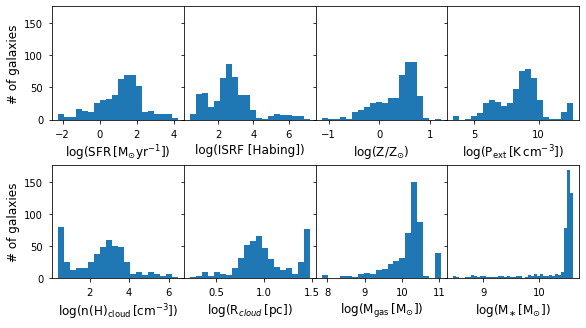

In [59]:
with plt.style.context(('seaborn-paper')):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    fig, axes = plt.subplots(2, 4, figsize=(9.44, 5), sharey=True)
    axs = axes.ravel()
    for ipar in range(8):
#         hist(pred_readable[lab_pars[ipar]],
#              density=False, bins='freedman', ax=axs[ipar])
        axs[ipar].hist(pred_readable[lab_pars[ipar]], bins=20 if ipar < 7 else 40)
        axs[ipar].set_xlabel(r'log('+lab_pars[ipar]+')')
    axs[0].set_ylabel('# of galaxies')
    axs[4].set_ylabel('# of galaxies')
    plt.subplots_adjust(wspace=0, hspace=0.4)
    plt.savefig('../figures/Observations_predictions.pdf',
                dpi=300, bbox_inches='tight')  # For Paper

## Reference selected images DiagISM
We print the rows of the two selected galaxies that we show as an examples in the text.

In [24]:
dat_pd_A[6:8]

,Name,SIMBADName,RA,DEC,Reference,z,SIMBADType,SFR,SFR_err,LimSFR,...,LimCII,LNII205,LNII205_err,LimNII205,Lum_OIII_52,Lum_NIII_57,Lum_OI_63,Lum_OIII_88,Lum_CII_158,Lum_NII_205
9,Circinus Galaxy,NAME Circinus Galaxy,14 13 09.906,-65 20 20.47,2008ApJS..178..280B,0.000608,Seyfert_2,0.404353,NaN,0.0,...,0.0,NaN,<NA>,0.0,NaN,NaN,7.481094,7.036051,7.531479,NaN
12,ESO 173-G015,ESO 173-15,13 27 23.774,-57 29 22.14,2008ApJS..178..280B,0.004321,Galaxy,1.560742,NaN,0.0,...,0.0,NaN,<NA>,0.0,NaN,NaN,8.404012,8.345714,8.505150,NaN


In [25]:
sfr_m8all_setb = Table.read('../data/processed/outputs_DiagISM/obs_sfr/DiagISM_result_M8all_SFR_A.csv',
                            format='ascii.csv', header_start=5)
sfr_m2plus_setb = Table.read('../data/processed/outputs_DiagISM/obs_sfr/DiagISM_result_M2plus_SFR_A.csv',
                             format='ascii.csv', header_start=5)
print(sfr_m8all_setb[6:8])
print(sfr_m2plus_setb[6:8])

 id       per_16th      ...        mean               std        
--- ------------------- ... ------------------ ------------------
  6 0.33522559023744825 ... 0.6642551010679406 0.3414750989487691
  7  1.5873129975738913 ... 1.7478881554446344 0.1634317617935361
 id      per_16th      ...        mean                std        
--- ------------------ ... ------------------ -------------------
  6 0.5610237416686662 ... 0.6907984249645683 0.13831068003174385
  7 1.5246081725347198 ...  1.693545039666249 0.16998260707570467


##### Notebook info

In [26]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.59.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
matplotlib: 3.4.3
json      : 2.0.9
numpy     : 1.22.1
autopep8  : 1.5.7

Watermark: 2.2.0

